In [1]:
from bs4 import BeautifulSoup
import urllib.request
import pandas as pd
import scipy as sc
import numpy as np
import re
from pathlib import Path
import statsmodels.formula.api as sm
import matplotlib.pyplot as plt

In [2]:
url = "https://news.ycombinator.com/news?p="
# here we actually access the website
count = 1
pages = []
while count < 6:
    with urllib.request.urlopen(url+ str(count)) as response:
        html = response.read()
        html = html.decode('utf-8')
        pages.append(html) 
        count += 1

In [3]:
# save the file
with open('hacker_news.html', 'w') as new_file:
    for page in pages: 
        new_file.write(page);

soup = BeautifulSoup(open("hacker_news.html"), 'html.parser')

In [4]:
class Article():
    def __init__(self):
        pass
        self.rank = None
        self.title = None
        self.age = None
        self.points = None
        self.comCount = None
        self.titleLen = None
    def setAge(self, age):
        if age is None:
            self.age = 0
        else:
            self.ageToMinutes(age.string)
    
    def setTitle(self, title):
        if title is None:
            self.title = ''
        else:
            self.title = title.string
            self.titleLen = len(title.string)
    
    def setRank(self, rank):
        if rank is None:
            self.rank = 0
        else:
            self.cleanRank(rank.string)
    
    def setPoints(self, points):
        if points is None:
            self.points = 0
        else:
            self.parsePoints(points.string)
            
    def setComCount(self, comments):
        if comments is None:
            self.comCount = 0
        elif 'comment' not in comments.string:
            self.comCount = 0
        else:
            self.parseComments(comments.string)
            
    def ageToMinutes(self, age):
        ageArr = age.split( )
        ageArr[0] = int(ageArr[0])
        if 'day' in ageArr[1]:
            self.age = ageArr[0] * 24 * 60
        elif 'hour' in ageArr[1]:
            self.age = ageArr[0] * 60
        elif 'minute' in ageArr[1]:
            self.age = ageArr[0]
        else:
            print("age unknown")
            self.age = 0;
            
    def parsePoints(self, points):
        pointsArr = points.split( )
        self.points = int(pointsArr[0])
        
    def parseComments(self, comments):
        commentsArr = comments.split( )
        self.comCount = int(commentsArr[0])
        
    def cleanRank(self, rank):
        rank = re.sub('[^0-9]','', rank)
        self.rank = int(rank)
        
    def to_dict(self):
        return {
            'title': self.title,
            'titleLen': self.titleLen,
            'rank':self.rank,
            'age': self.age,
            'points': self.points,
            'comCount': self.comCount
        }
       

In [5]:
tables = soup.find_all("table", class_="itemlist")
rows = []
articles =[]
for table in tables:
    table_rows = table.find_all("tr", class_="athing")
    for row in table_rows:
        article = Article()
        rank = row.find('span', class_="rank").string
        article.setRank(rank)
        
        title = row.find('a', class_="storylink")
        article.setTitle(title)
        
        subtext_row = row.find_next_sibling('tr')
        age = subtext_row.find('span', class_="age")
        article.setAge(age)

        points = subtext_row.find('span', class_="score")
        article.setPoints(points)
        
        smlTxtSpans = subtext_row.find_all('td', class_="subtext")
        commentCount = smlTxtSpans[0].find_all('a')[-1]
        article.setComCount(commentCount)
        
        rows.append(row)
        rows.append(subtext_row)
        articles.append(article.to_dict())

print(len(rows))
print(len(articles))
# [print(row.prettify(), "\n\n\n") for row in rows[:10]]
# [print(article.age) for article in articles[:10]]



300
150


In [6]:
hn = pd.DataFrame.from_records(articles)

In [7]:
path = Path.cwd() / "hackernews.csv"
if not path.is_file():
    hn.to_csv("hackernews.csv")
    print("file created")
else:
    print("file already exists")

file already exists


## Part 2 - Regression

In [8]:
print(hn.describe())

               age    comCount       points        rank    titleLen
count   150.000000  150.000000   150.000000  150.000000  150.000000
mean    827.366667   68.806667   148.560000   75.500000   52.026667
std     590.077738   98.042430   186.476926   43.445368   16.749616
min      26.000000    0.000000     0.000000    1.000000   15.000000
25%     360.000000    4.000000    23.500000   38.250000   40.250000
50%     660.000000   29.000000    68.500000   75.500000   53.000000
75%    1380.000000   99.000000   190.500000  112.750000   64.750000
max    2880.000000  586.000000  1008.000000  150.000000   80.000000


In [9]:
hn.corr()

,age,comCount,points,rank,titleLen
age,1.000000,0.361392,0.508198,0.581427,-0.036270
comCount,0.361392,1.000000,0.746104,-0.029695,-0.028760
points,0.508198,0.746104,1.000000,-0.032342,-0.042011
rank,0.581427,-0.029695,-0.032342,1.000000,0.074013
titleLen,-0.036270,-0.028760,-0.042011,0.074013,1.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1169f6780>,
      dtype=object)

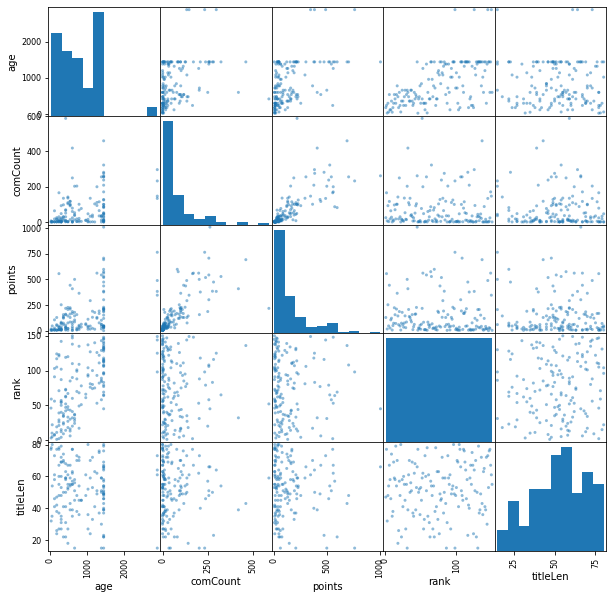

In [10]:
pd.plotting.scatter_matrix(hn, figsize=(10, 10))

In [11]:
rank_comCount_ols = sm.ols(data=hn, formula="rank ~ comCount").fit()
rank_comCount_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   rank   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.006
Method:                 Least Squares   F-statistic:                    0.1306
Date:                Wed, 05 Jun 2019   Prob (F-statistic):              0.718
Time:                        17:22:31   Log-Likelihood:                -778.00
No. Observations:                 150   AIC:                             1560.
Df Residuals:                     148   BIC:                             1566.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     76.4054      4.351     17.560      0.000      67.807      85.004
comCount      -0.0132      0.036     -0.361      0.718      -0.085       0.059
==============================================================================
Omnibus:                       59.461   Durbin-Watson:                   0.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                8.923
Skew:                          -0.005   Prob(JB):                       0.0115
Kurtosis:                       1.805   Cond. No.                         146.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Based on the above regression summary, it can be concluded that comCount explains almost none of the variance of Rank. The r2 value is 0.001 and the p value, which is the probability that there is no relationship between the variables is 72%. 

In [22]:
age_comCount_ols = sm.ols(data=hn, formula="rank ~ age").fit()
age_comCount_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   rank   R-squared:                       0.338
Model:                            OLS   Adj. R-squared:                  0.334
Method:                 Least Squares   F-statistic:                     75.58
Date:                Wed, 05 Jun 2019   Prob (F-statistic):           6.12e-15
Time:                        17:35:02   Log-Likelihood:                -747.12
No. Observations:                 150   AIC:                             1498.
Df Residuals:                     148   BIC:                             1504.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     40.0817      4.998      8.019      0.000      30.205      49.959
age            0.0428      0.005      8.694      0.000       0.033       0.053
==============================================================================
Omnibus:                        8.576   Durbin-Watson:                   0.659
Prob(Omnibus):                  0.014   Jarque-Bera (JB):                7.633
Skew:                           0.478   Prob(JB):                       0.0220
Kurtosis:                       2.444   Cond. No.                     1.75e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.75e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### age is still not a strong predictor of rank as only 34% of the variation in rank can be explained by age according to the r2 value. However, the probability that the relationship is 0 is 0 according to the p value. This is therefore much better than comCount

In [23]:
age_comCount_ols = sm.ols(data=hn, formula="rank ~ age + points").fit()
age_comCount_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   rank   R-squared:                       0.483
Model:                            OLS   Adj. R-squared:                  0.476
Method:                 Least Squares   F-statistic:                     68.65
Date:                Wed, 05 Jun 2019   Prob (F-statistic):           8.81e-22
Time:                        17:38:06   Log-Likelihood:                -728.59
No. Observations:                 150   AIC:                             1463.
Df Residuals:                     147   BIC:                             1472.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     41.6967      4.440      9.392      0.000      32.923      50.470
age            0.0593      0.005     11.705      0.000       0.049       0.069
points        -0.1030      0.016     -6.418      0.000      -0.135      -0.071
==============================================================================
Omnibus:                       13.468   Durbin-Watson:                   0.927
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               15.162
Skew:                           0.779   Prob(JB):                     0.000510
Kurtosis:                       2.971   Cond. No.                     1.78e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.78e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Together age and points can explain 48% of the variation in rank. This is an improvement over age alone and our p value for points is also 0. Therefore, this is a better model than the previous.

In [24]:
age_comCount_ols = sm.ols(data=hn, formula="rank ~ age + points + titleLen").fit()
age_comCount_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   rank   R-squared:                       0.490
Model:                            OLS   Adj. R-squared:                  0.480
Method:                 Least Squares   F-statistic:                     46.78
Date:                Wed, 05 Jun 2019   Prob (F-statistic):           3.01e-21
Time:                        17:39:57   Log-Likelihood:                -727.54
No. Observations:                 150   AIC:                             1463.
Df Residuals:                     146   BIC:                             1475.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     30.0482      9.247      3.249      0.001      11.772      48.324
age            0.0595      0.005     11.770      0.000       0.049       0.069
points        -0.1023      0.016     -6.399      0.000      -0.134      -0.071
titleLen       0.2201      0.153      1.434      0.154      -0.083       0.523
==============================================================================
Omnibus:                       12.511   Durbin-Watson:                   0.965
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               13.920
Skew:                           0.746   Prob(JB):                     0.000949
Kurtosis:                       2.946   Cond. No.                     3.73e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.73e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Adding the title length does not do much to improve our model increasing the r2 value less than 1 percent. TitleLen also has a p value of 15.4%. Therefore, because our previous model is nearly just as accurate and less complex, I will stick with that model instead of adopting this one. 

### Part 3 - Classification

In [15]:
firstPage = []
def isFrontPage(rank):
    return  0 if rank > 30 else 1

[firstPage.append(isFrontPage(rank)) for rank in hn['rank']]

firstPage = np.array(firstPage)
isFrontPg = pd.DataFrame(firstPage, columns = ["isFrontPg"])
frames = [hn, isFrontPg]
hn = pd.concat(frames, axis = 1)
print(hn)

      age  comCount  points  rank  \
0     180        24     128     1   
1     240       165     555     2   
2      31         6      16     3   
3     300        92     252     4   
4      60         2      46     5   
5     540       116     442     6   
6     120        17      25     7   
7     120        63     105     8   
8     360        27     121     9   
9      54         0       6    10   
10    180        12      49    11   
11    300         6      72    12   
12    540        96     223    13   
13    420        69     155    14   
14    300        17      70    15   
15    540       100     210    16   
16    780       100     364    17   
17    480       141     143    18   
18    180        17      58    19   
19    600       249     186    20   
20    240        29      45    21   
21     60         0       6    22   
22    360        16      73    23   
23    660        12     178    24   
24    360         7      59    25   
25    240         4      34    26   
2

In [16]:
print(hn.columns)
lr_comCount = sm.logit(formula="isFrontPg ~ comCount", data=hn).fit()
lr_comCount.summary()

Index(['age', 'comCount', 'points', 'rank', 'title', 'titleLen', 'isFrontPg'], dtype='object')
Optimization terminated successfully.
         Current function value: 0.496934
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              isFrontPg   No. Observations:                  150
Model:                          Logit   Df Residuals:                      148
Method:                           MLE   Df Model:                            1
Date:                Wed, 05 Jun 2019   Pseudo R-squ.:                0.006930
Time:                        17:22:31   Log-Likelihood:                -74.540
converged:                       True   LL-Null:                       -75.060
                                        LLR p-value:                    0.3077
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.2371      0.248     -4.980      0.000      -1.724      -0.750
comCount      -0.0024      0.003     -0.955      0.339      -0.007       0.003
==============================================================================
"""

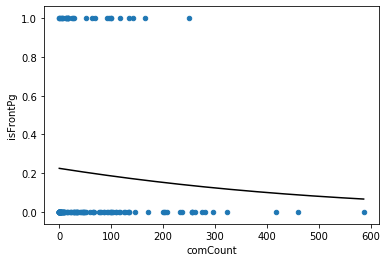

In [17]:
factors = hn[['comCount','age','points', 'titleLen', 'isFrontPg', 'rank']]
# print(factors)
factors.plot.scatter(x='comCount', y='isFrontPg')
logistic = lambda x: 1 / (1 + sc.exp(-x))
params = dict(lr_comCount.params)

x = sc.linspace(factors['comCount'].min(),factors['comCount'].max(),1000)
plt.plot(x, logistic(params['Intercept'] + params['comCount']* x), color ="black", label='logistic(x)')

Optimization terminated successfully.
         Current function value: 0.370076
         Iterations 8


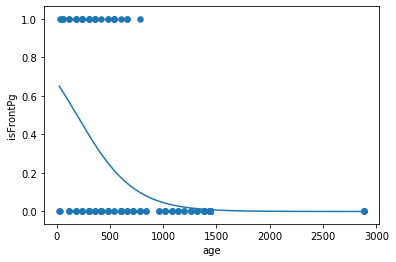

In [18]:
lr_age = sm.logit(formula="isFrontPg ~ age", data=hn).fit()
x = sc.linspace(factors['age'].min(), factors['age'].max(), 1000)
factors.plot.scatter(x='age', y="isFrontPg", s=30)
params = dict(lr_age.params)
plt.plot(x, logistic(params['Intercept'] + params['age']*x))

In [19]:
lr_all = sm.logit(formula="isFrontPg ~ comCount + age + points + titleLen", data=factors).fit()

factors['pred_all'] = lr_all.predict()>.5
display(pd.crosstab(index=factors["isFrontPg"], columns=factors["pred_all"])) 
lr_all.summary()

Optimization terminated successfully.
         Current function value: 0.324819
         Iterations 8


pred_all,False,True
isFrontPg,,
0,112,8
1,18,12


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              isFrontPg   No. Observations:                  150
Model:                          Logit   Df Residuals:                      145
Method:                           MLE   Df Model:                            4
Date:                Wed, 05 Jun 2019   Pseudo R-squ.:                  0.3509
Time:                        17:22:32   Log-Likelihood:                -48.723
converged:                       True   LL-Null:                       -75.060
                                        LLR p-value:                 9.966e-11
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.4224      0.910      1.563      0.118      -0.361       3.206
comCount      -0.0038      0.004     -0.951      0.342      -0.012       0.004
age           -0.0060      0.001     -4.387      0.000      -0.009      -0.003
points         0.0089      0.003      3.218      0.001       0.003       0.014
titleLen      -0.0099      0.015     -0.678      0.498      -0.039       0.019
==============================================================================
"""

In [20]:
lr_points = sm.logit(formula="isFrontPg ~ points", data=factors).fit()
lr_points.summary()
factors['pred_points'] = lr_points.predict()>.5
display(pd.crosstab(index=factors["isFrontPg"], columns=factors["pred_points"])) 

Optimization terminated successfully.
         Current function value: 0.499332
         Iterations 5


pred_points,False
isFrontPg,
0,120
1,30


In [21]:
lr_age_points = sm.logit(formula="isFrontPg ~  age + points", data=factors).fit()

factors['pred_age_points'] = lr_age_points.predict()>.5
display(pd.crosstab(index=factors["isFrontPg"], columns=factors["pred_age_points"])) 
lr_age_points.summary()

Optimization terminated successfully.
         Current function value: 0.329686
         Iterations 8


pred_age_points,False,True
isFrontPg,,
0,113,7
1,18,12


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              isFrontPg   No. Observations:                  150
Model:                          Logit   Df Residuals:                      147
Method:                           MLE   Df Model:                            2
Date:                Wed, 05 Jun 2019   Pseudo R-squ.:                  0.3412
Time:                        17:22:32   Log-Likelihood:                -49.453
converged:                       True   LL-Null:                       -75.060
                                        LLR p-value:                 7.565e-12
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.8388      0.446      1.882      0.060      -0.035       1.712
age           -0.0059      0.001     -4.376      0.000      -0.009      -0.003
points         0.0073      0.002      3.227      0.001       0.003       0.012
==============================================================================
"""

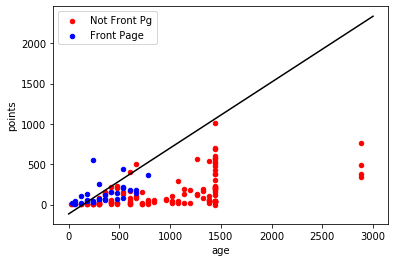

In [35]:
ax = factors[factors['isFrontPg']==0].plot.scatter(x='age',y='points',color='red',label='Not Front Pg')
factors[factors['isFrontPg']==1].plot.scatter(x='age',y='points',color='blue',label='Front Page', ax=ax)
x = sc.linspace(0,3000,1000)
params = dict(lr_age_points.params)
odds = lambda p: p/(1-p)
logit = lambda p: sc.log(odds(p))
plt.plot(x,(1/params['points'])*(logit(.5) - params['Intercept'] - params['age']*x),color='Black')

#### The above analysis would suggest that none of the equations above will acurately predict which post is on the front page reliably. Our best model is to use age and points together which accurately predicts some of the time, but also has a lot of false negatives where it will predict articles not being on the front page when they actually are. 